# The Data

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which we'll be working with in this project. The file contains 17380 rows, and each row represents the bike rentals in a single hour of a single day

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

os.chdir(r"C:\Users\gerr1\Desktop\Data Science Portfolio\data\bike data")
bikes = pd.read_csv("hour.csv")

print(bikes.shape)
bikes.head()

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In this project, we will try to predict the total number of bikes rented in a given hour. We'll predict the cnt column using all the other columns, except casual and registered. To do this, we will create a few different machine learning models and evaluate their performance.

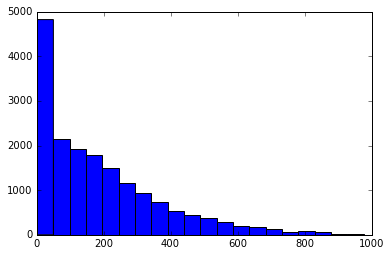

In [2]:
#Make a histogram of the cnt column of bike_rentals, and take a look at the distribution of total rentals
plt.hist(bikes.cnt, bins=20)
plt.show()

Here, we see a unimodal distribution that is entirely skewed right. We can see from the histogram that this distribution tapers off dramatically after count equals 50. Meaning in a regular hour, there are most likely between 0-50 bikes being rented.

In [3]:
#Use the corr method on the bikes Dataframe to explore how each column is correlated with cnt
print(bikes.corr()["cnt"])

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64


# Calculating Features

Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the hr column in bikes contains hours that bikes are rented, from 1 to 24. An algorithm will treat each hour differently, and not understand that certain hours are related. We can introduce some order into this by creating a new column with labels for morning, afternoon, evening, and night. This will bundle up similar times together, and enable the model to make better decisions.

In [4]:
#Write a function called assign_label that takes in a numeric hour value and returns 1 if the hour is from 6 to 12, 
#2 if the hour is from 12 to 18, 3 if the hour is from 18 to 24, 4 if the hour is from 0 to 6
def assign_label(hr):
    if hr >= 6 and hr < 12:
        return 1
    elif hr >= 12 and hr < 18:
        return 2
    elif hr >= 18 and hr < 24:
        return 3
    elif hr >= 0 and hr < 6:
        return 4
    
#Using the apply method on Series to apply the function to each item in the hr column.
#Assign the result to the time_label column of bikes
bikes["time_label"] = bikes["hr"].apply(assign_label)

bikes.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


# Splitting into Train & Test sets

The error metric we will be using is the mean squared error. Since our data is numeric, this metric makes the most sense.

In [5]:
#Now splitting the data; 80% will go to the training set while 20% will go to the test set. Also setting random state
train = bikes.sample(frac=.8, replace=False, random_state=8)
test = bikes[~bikes.index.isin(train.index)]

print("Size of Training set:", train.shape[0])
print("Size of Test set:", test.shape[0])

Size of Training set: 13903
Size of Test set: 3476


# Applying Linear Regression

Linear regression will likely work fairly well on this data, given that many of the columns are highly correlated with cnt.

We'll need to ignore the casual and registered columns because cnt is derived from these columns. If you're trying to predict the number of people who rent bikes in a given hour (cnt), it doesn't make sense that you'd already know casual or registered, because those numbers are added together to get cnt.

In [6]:
#Creating a list of feature columns to use in training and predictions
features = list(train.columns)
features.remove("cnt")
features.remove("casual")
features.remove("registered")
features.remove("dteday")

In [7]:
#Using the LinearRegression class from sklearn to train a machine learning algorithm on train using only the columns 
#in the features list for this
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train[features], train["cnt"])

#Making predictions using the LinearRegression class on the test set
predictions = lr.predict(test[features])

#Calculating the MSE between the predictions and the actual values
MSE = mean_squared_error(test["cnt"], predictions)
print("Mean Squared Error for LR model:", MSE)

Mean Squared Error for LR model: 16863.2167976


Although we have no point of reference, it seems the error on our model is pretty high. We could go through and eliminate certain columns to try and improve the accuracy, but it would be a better use of resources to train a model other than a linear regression one.

# Applying Decision Trees

We're now ready to apply the decision tree algorithm. We'll be able to compare the error with the error from the linear regression model, which will enable us to pick the right algorithm for this dataset.

In [8]:
#Using the DecisionTreeRegressor class to fit a decision tree algorithm to the train data
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(train[features], train["cnt"])

dt_predictions = dt.predict(test[features])
mse = mean_squared_error(test["cnt"], dt_predictions)
print("Mean Squared Error for DT model:", mse)

Mean Squared Error for DT model: 3392.91455696


We see that when we train a decision tree without parameters, we get a MSE of 3297.98 which is considerably less than the MSE of our linear regression model, 16863.22. However, this decision tree could also be grossly overfitting the data. We are going to hopefully avoid overfitting by setting some parameters in our new decision tree.

In [9]:
#Using the DecisionTreeRegressor class to fit a decision tree algorithm with some defined parameters
dt2 = DecisionTreeRegressor(min_samples_leaf=5, max_depth=7)
dt2.fit(train[features], train["cnt"])

dt2_predictions = dt2.predict(test[features])
mse2 = mean_squared_error(test["cnt"], dt2_predictions)
print("Mean Squared Error for paramaterized decision tree:", mse2)

Mean Squared Error for paramaterized decision tree: 8396.16960113


As you see, our error increased from the non-paramaterized decision tree. But, as per the bias/variance tradeoff, our second decision tree has less variation, more bias, but will most likely generalize better to unseen data than our original tree. Now we will attempt to improve our model even more by employing a Random Forest.

# Applying Random Forests

We will now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Because of how random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, and tuning parameters such as maximum depth and minimum samples per leaf is important.

In [10]:
#Use the RandomForestRegressor class to fit a random forest algorithm to the training data with 10 estimators
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10)
rf.fit(train[features], train["cnt"])

rf_predictions = rf.predict(test[features])
rf_mse = mean_squared_error(test["cnt"], rf_predictions)
print("Mean Squared Error for the Random Forest:", rf_mse)

Mean Squared Error for the Random Forest: 1894.23823072


We can see that our error improved tremendously from either decision tree algorithm we created, and due to the design of random forests, we know that is generalizes to unseen data fairly well. Now, we will try one last random forest model with a few more parameters defined.

In [11]:
rf2 = RandomForestRegressor(n_estimators=10, max_depth=7, min_samples_leaf=5)
rf2.fit(train[features], train["cnt"])

rf2_predictions = rf2.predict(test[features])
rf2_mse = mean_squared_error(test["cnt"], rf2_predictions)
print("Mean Squared Error for the second Random Forest:", rf2_mse)

Mean Squared Error for the second Random Forest: 6127.73408066


Once again, because we set some paramaters to avoid overfitting, we will see a bit more bias in our model. However, with some cross-validation, we can find the best settings for our random forest so it will generalize well. Regardless, this most recent ML model we have created is most likely the best model to use for predicting bike rentals in a given hour. 

# Further Analysis

The analysis is never complete. Here are some further questions and analyses:

Calculate more features, such as:

    An index combining temperature, humidity, and wind speed.
    
    Try predicting casual and registered instead of cnt